# ATRX trans effect histograms


This notebook analyzes the trans effect of ATRX mutation for all proteins.

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import cptac
import cptac.utils as al

In [2]:
brain = cptac.Gbm()

In [3]:
def add_to_all_significant_comparisons(df, cancer, interacting, all_sig_comp):
    expanded = df
    expanded['Gene'] = gene
    expanded['Cancer_Type'] = cancer
    expanded['Interacting_Protein'] = interacting
    
    updated_all_comparisons = pd.concat([all_sig_comp, expanded], sort=False)
    
    return updated_all_comparisons

In [4]:
def add_significance_col(results_df, num_comparisons):
    #bonferroni multiple hypothesis
    
    #FIX! 
    alpha = .05
    bonferroni_cutoff = alpha / num_comparisons
    
    for row_index, row in results_df.iterrows():
        pval = row['P_Value']
        if float(pval) <= bonferroni_cutoff:
            results_df['Significant'] = True
        else: 
            results_df['Significant'] = False
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests = None, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        if total_tests == None:
            number_of_comparisons = len(comparison_columns)
            print(number_of_comparisons)
        else:
            number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


### Specify Gene

In [5]:
gene = "ATRX"

###  Transcriptomics

In [6]:
#omics = "proteomics"
omics = "transcriptomics"
#omics = "phosphoproteomics"

### Track all significant comparisons in dataframe

In [7]:
all_significant_comparisons = pd.DataFrame(columns=['Cancer_Type', 'Gene', 'Comparison','Interacting_Protein','P_Value'])

# All Proteins: Transcriptomics

In [8]:
try:
    print("\nGene: ", gene)

    #Use all proteins

    #Create dataframe in order to do comparisons with wrap_ttest
    protdf = brain.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics)
    protdf = brain.reduce_multiindex(protdf, flatten=True)
    protdf = protdf[protdf.Sample_Status == 'Tumor'] # drop Normal samples
    
    #Create the binary valued column needed to do the comparison
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    #Format the datafram correctly
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    #Make list of columns to be compared using t-tests
    col_list = list(protdf.columns)
    col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    wrap_results = wrap_ttest_return_all(protdf, 'Label', col_list)

    all_significant_comparisons = add_to_all_significant_comparisons(wrap_results, "Gbm", False, all_significant_comparisons)
    print("done")

except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  ATRX


Doing t-test comparisons

60483
done


### Print all significant comparisons

In [9]:
if len(all_significant_comparisons) > 0:
    sig = all_significant_comparisons.loc[all_significant_comparisons['Significant'] == True]
    print(sig)
    number_of_proteins = len(all_significant_comparisons)
    print("number of proteins: ", number_of_proteins)
else:
    print('No Significant Comparisons!')

Empty DataFrame
Columns: [Cancer_Type, Gene, Comparison, Interacting_Protein, P_Value, Significant]
Index: []
number of proteins:  60483


In [10]:
# Significant comparisons
cutoff = 0.000000826 #(.05/60483)
sig_df = all_significant_comparisons.loc[all_significant_comparisons['P_Value'] <= cutoff]


In [11]:
alpha = .05
num_comparisons = 60843
bonferroni_cutoff = alpha / num_comparisons
sig = []
#pval = 7.035771e-07

for row_index, row in sig_df.iterrows():
    pval = row['P_Value']
    if float(pval) <= bonferroni_cutoff:
        sig.append(True)
    else: 
        sig.append(False)

In [12]:
pval_series = all_significant_comparisons['P_Value']
pval_series = pval_series.dropna()

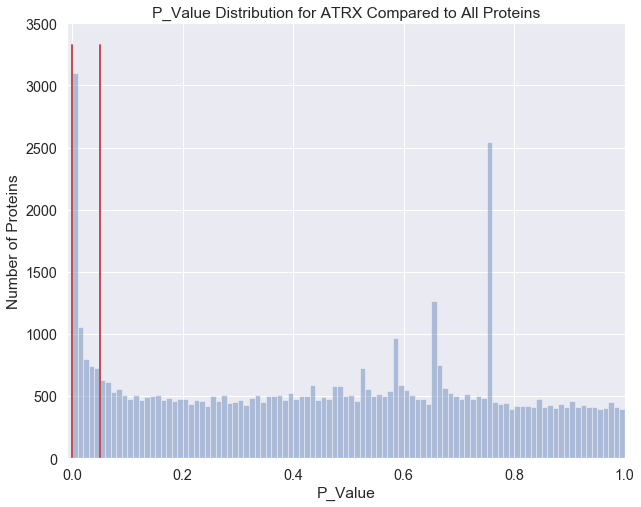

In [13]:
# Histogram
bonferroni_cutoff = 0.05/number_of_proteins

plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)
histogram = sns.distplot(pval_series, bins = 100, kde=False)
plt.xlim([-.01, 1]) # change x axis intervals
plt.ylim([0, 3500])
histogram.set_title("P_Value Distribution for "+gene+" Compared to All Proteins")
histogram.set(ylabel = 'Number of Proteins')

# Graph cutoffs
plt.axvline(bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='r')

plt.show()
plt.clf()
plt.close()

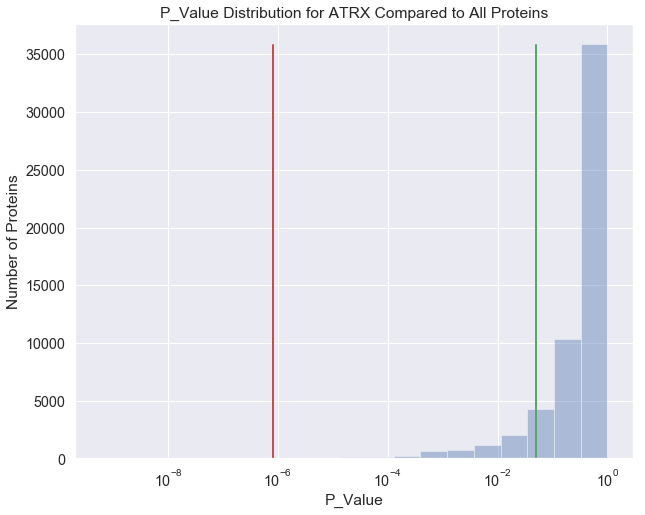

In [28]:
# Histogram LOG
bonferroni_cutoff = 0.05/number_of_proteins

plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

#plt.xlim([1e-10, 1]) # change x axis intervals
plt.xscale('log')
LogMin, LogMax = np.log10(pval_series.min()), np.log10(pval_series.max())
newBins = np.logspace(LogMin, LogMax, 20)
histogram = sns.distplot(pval_series, bins = newBins, kde=False) # bins 100 
#plt.ylim([0, 3500])



histogram.set_title("P_Value Distribution for "+gene+" Compared to All Proteins")
histogram.set(ylabel = 'Number of Proteins')

# Graph cutoffs
plt.axvline(bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()

plt.clf()
plt.close()



# Zoom in (only shows bonferroni cutoff)

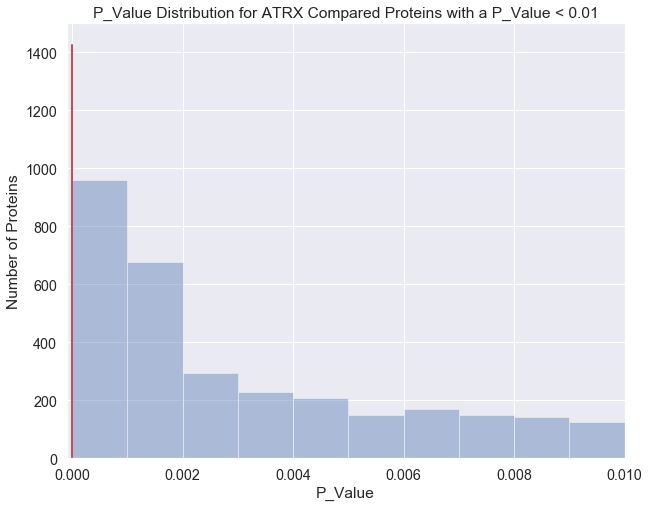

In [47]:
# Histogram
bonferroni_cutoff = 0.05/number_of_proteins

plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

histogram = sns.distplot(pval_series, bins = 1000, kde=False)# higher bins (1000) if you don't log it *3 BINS rwidth **
plt.xlim([-.0001,0.01])
plt.ylim([0.0,1500]) # change y axis intervals
histogram.set_title("P_Value Distribution for "+gene+" Compared Proteins with a P_Value < 0.01")
histogram.set(ylabel = 'Number of Proteins')
plt.axvline(bonferroni_cutoff, 0, 0.95, linewidth=2, color='r') # cutoff line (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

In [37]:
# Select p-values within range 0 - end_value 
end_value = 0.01
zoomed = pval_series.loc[pval_series <= end_value]

# Histogram LOGGED
bonferroni_cutoff = 0.05/number_of_proteins

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)


# Create log scale for the x-axis
plt.xscale('log')
LogMin, LogMax = np.log10(zoomed.min()),np.log10(zoomed.max())
newBins = np.logspace(LogMin, LogMax, 20) # change this number for more or less bins
histogram = sns.distplot(zoomed, bins = newBins, kde=False)

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" Compared Proteins with a P_Value < " + str(end_value))
histogram.set(ylabel = 'Number of Proteins')
plt.ylim([0.0,1000]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

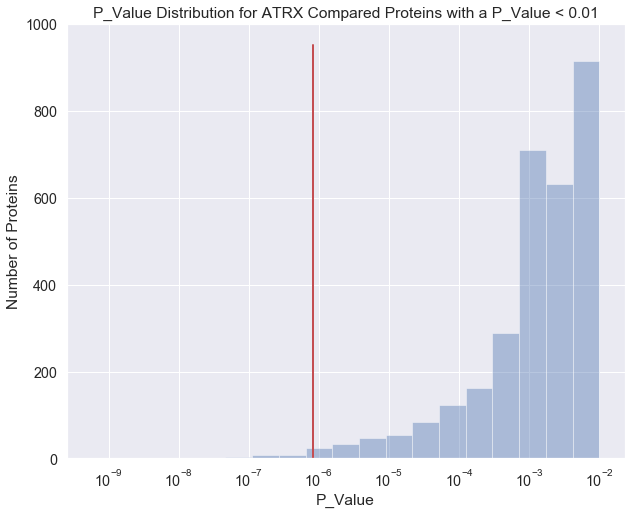

In [45]:
# Histogram LOGGED
bonferroni_cutoff = 0.05/number_of_proteins

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)


# Create log scale for the x-axis
plt.xscale('log')
LogMin, LogMax = np.log10(zoomed.min()),np.log10(zoomed.max())
newBins = np.logspace(LogMin, LogMax, 20) # change this number for more or less bins
histogram = sns.distplot(zoomed, bins = newBins, kde=False)

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" Compared Proteins with a P_Value < " + str(end_value))
histogram.set(ylabel = 'Number of Proteins')
plt.ylim([0.0,1000]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()